## Procedure for fitting the model to IB data

For this procedure we simulate the model for many combinations of the parameters and find the one that best matches the observed data. 

### Epidemiological data

Time series available are

* Deaths (official data)
* Deaths (press data)
* UCI patients
* Recovered patients
* Infected patients
* Hospitalized patients

### Results of the model

Time series from the model

* Infected
* Recovered

### Fitting model to data

In order to fit the model to the data we proceed in the following way for each combination of parameters:

1. Fix a proportion of recovered patients that actually die. ($\mu_D$)
2. Shift rescaled curve of recovered patients by tau from the model to best fit the curve of deaths from the data. The best fit is assessed by a $\chi^2$ function.
3. With that tau move also the curve of infected from the model and rescale it to best match the curve of UCI patients. Best value of this variable also given by Chi squared. ($\mu_{UCI}$)
4. Assign to this set of parameters the $\chi^2$ that is the sum of the ones in 2. and 3. and save it together with the parameter values, the proportion of deaths and the obtained parameters tau and proportion of infected in UCI.

From all the $\chi^2$ values choose the one that is minimum.

## Code

Import necessary modules.

In [261]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import glob
import sys

Read epidemic data.

In [296]:
# do a shift in the dates for the model
def shift(df, Ndays):
    dates = list(df['Día'])
    timedelta = dt.timedelta(days = Ndays)
    newdates = [dates[i] - timedelta for i in range(len(dates))]
    dfnew = df.copy()
    dfnew['Día'] = newdates
    return dfnew

In [283]:
# do the chi-chi
def chi2(df, cname1, cname2, par):
    chi2 = 0.0
    df2_ = df[df[cname1].notna()]
    a = np.array(df2_[cname1])
    b = np.array(df2_[cname2])*par
    chi2 = np.sum(np.square(a - b))
    del df2_
    return chi2, par

In [284]:
#read epi data and make day a datetime object
df_epi = pd.read_csv('../data/epi_data_IB.csv')
df_epi['Día'] = pd.to_datetime(df_epi['Día'], dayfirst = True)
df_epi.head()

,Mpres,I,14d,H,UCI,M,Curad,NuevoI,Día
0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-26
1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-27
2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01
3,NaN,2,0.17,NaN,0.0,0.0,NaN,NaN,2020-03-02
4,NaN,5,0.43,NaN,0.0,0.0,NaN,NaN,2020-03-03


In [285]:
#fname = '../results/time_ave_r_sd_i_sd_format0.csv'
fname = '../results/time_av_6_19_0.9.dat'
def best_fit(df_epi, fname_simu = fname, mu_D = 0.01, Ndays = 50):
    fname2 = fname_simu.split('.dat')[0]+'_format0.dat'
    os.system("awk '$1=$1' "+fname+" > "+fname2)
    df_simu = pd.read_csv(fname2, sep = ' ')
    os.system('rm '+fname2)
    date0 = dt.datetime(day = 29, month = 2, year = 2020)
    datenums = list(df_simu['#time'])
    dates = [date0 + dt.timedelta(days = datenums[i]) for i in range(len(datenums))]
    df_simu['Día'] = dates
    chi_2_M = float("inf")
    dayshift = 0
    for iday in range(Ndays):
        df_shifted = shift(df_simu, iday)
        df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
        chichi, par = chi2(df_merged, 'M', 'average_recover', mu_D)
        if chichi < chi_2_M:
            chi_2_M = chichi
            dayshift = iday
    v1=np.arange(0.00001,0.005,0.00001)
    df_shifted = shift(df_simu, dayshift)
    df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
    #print(df_merged.head())
    #sys.exit()
    chi_2_UCI = float("inf")
    mu_UCI = 0.0
    for par in v1:
        chichi, muci = chi2(df_merged, 'UCI', 'average_infected', par)
        if chichi < chi_2_UCI:
            chi_2_UCI = chichi
            mu_UCI = muci
    chichi = chi_2_M + chi_2_UCI
    return chichi, dayshift, mu_UCI

In [286]:
files = glob.glob("../results/time_av_*")
percents = [0.01, 0.006, 0.034]
f = {}
day_sh = {}
mu_U = {}
for perc in percents:
    chi_2 = float("inf")
    for fname in files:
        params = fname.split('.dat')[0].split('_')[2:]
        params[0] = int(params[0])
        params[1] = int(params[1])
        params[2] = np.round(float(params[2]),1)
        chichi, dayshift_, mu_UCI_ = best_fit(df_epi, fname_simu = fname, mu_D = perc)
        if chichi < chi_2:
            chi_2 = chichi
            fgood = fname
            dayshift = dayshift_
            mu_UCI = mu_UCI_
    f[perc] = fgood
    day_sh[perc] = dayshift
    mu_U[perc] = mu_UCI
    #print(list(best_fit(df_epi, fname_simu = fname, mu_D = 0.01)))
    print(perc, chi_2, fgood, dayshift, mu_UCI)

0.01 399.2749713334107 ../results/time_av_5_18_0.30000000000000004.dat 37 0.00027000000000000006
0.006 644.749995290896 ../results/time_av_5_18_0.30000000000000004.dat 39 0.00022
0.034 526.6208890814632 ../results/time_av_6_19_0.4.dat 33 0.00041000000000000005


3    2020-03-02
4    2020-03-03
5    2020-03-04
6    2020-03-05
7    2020-03-08
8    2020-03-09
9    2020-03-10
10   2020-03-11
11   2020-03-12
12   2020-03-13
13   2020-03-14
14   2020-03-15
15   2020-03-16
16   2020-03-17
17   2020-03-18
18   2020-03-19
19   2020-03-20
20   2020-03-21
21   2020-03-22
22   2020-03-23
23   2020-03-24
24   2020-03-25
25   2020-03-26
26   2020-03-27
27   2020-03-28
28   2020-03-29
29   2020-03-30
30   2020-03-31
Name: Día, dtype: datetime64[ns]

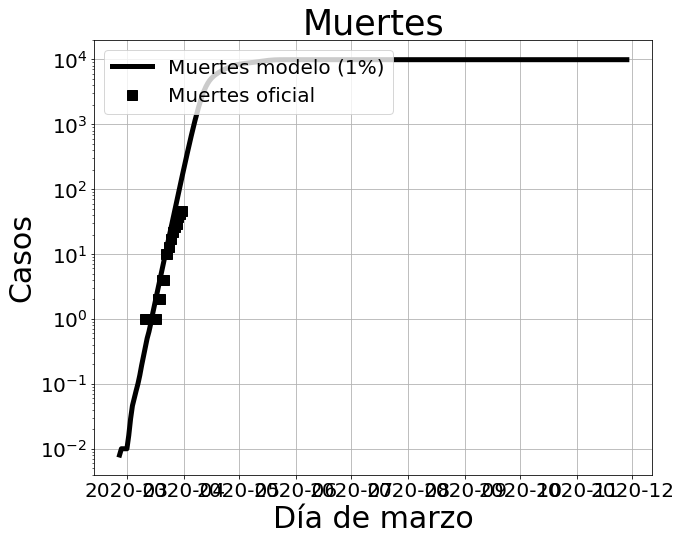

In [304]:
#datos reales
df2 = df_epi[df_epi['M'].notna()]
x = df2['Día']
y = list(df2['M'])
#resultados modelo
fname2 = f[0.01].split('.dat')[0]+'_format0.dat'
os.system("awk '$1=$1' "+fname+" > "+fname2)
df_simu = pd.read_csv(fname2, sep = ' ')
os.system('rm '+fname2)
date0 = dt.datetime(day = 29, month = 2, year = 2020)
datenums = list(df_simu['#time'])
dates = [date0 + dt.timedelta(days = datenums[i]) for i in range(len(datenums))]
df_simu['Día'] = dates
df_simu = shift(df_simu, day_sh[0.01])
x_model = np.array(df_simu['Día'])
y_model = np.array(df_simu['average_recover'])
#print(y_model_inf/y_model_inf[49])
plt.figure(figsize = (10, 8))
plt.plot(x_model, y_model*0.01, c = 'k', label= 'Muertes modelo (1%)', lw = 5)
#plt.fill_between(x_model[36:]-22, y_model[36:]*0.006, y_model[12:len(y_model)-24]*3.4, color = 'gray', label= 'Muertes modelo (0.6%-3.4%)', lw = 5)
#plt.plot(x_model[34:]-20, y_model_inf[34:]*y_uci[-1]/y_model_inf[34], 'r--', label= 'UCI modelo', lw = 5)
#plt.plot(x_model-20, y_model_inf*y_inf[-1]/y_model_inf[34], c='r', label= 'Infectados modelo')
#plt.plot(x, y_m, 'ko', label = 'Muertes prensa')
#plt.plot(x, y_inf, 'r^', label = 'Infectados')
#plt.plot(x, y_uci, 'rX', label = 'UCI', ms = 10)
#plt.figsize((12, 12))
plt.plot(x, y, 'ks', label = 'Muertes oficial', ms = 10)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Día de marzo', fontsize = 30)
plt.ylabel('Casos', fontsize = 30)
#plt.xlim((15,35))
#plt.ylim((1,1000))
plt.title('Muertes', fontsize = 35)
plt.legend(fontsize = 20, loc = 2)
plt.savefig('../figures/muertes_01_04_2020.png')

Read data from simulations (this has to be converted into a loop over all the simulation data files).

In [73]:
#read simulation data and make time into date as datetime object 
#and put it into new column 'Día' to later merge with df_epi
df_simu = pd.read_csv('../results/time_ave_r_sd_i_sd_format0.csv', sep = ' ')
#date0 = dt.datetime.strptime('29/02/2020', '%d/%m/%Y')
date0 = dt.datetime(day = 29, month = 2, year = 2020)
datenums = list(df_simu['time'])
dates = [date0 + dt.timedelta(days = datenums[i]) for i in range(len(datenums))]
df_simu['Día'] = dates
df_simu.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día
0,15,1.0,0.000000,19.7,7.376313,2020-03-15
1,16,1.0,0.000000,27.0,11.081516,2020-03-16
2,17,1.0,0.000000,34.8,13.075167,2020-03-17
3,18,1.0,0.000000,46.4,17.442477,2020-03-18
4,19,1.6,0.663325,59.2,22.569005,2020-03-19


In [75]:
df_shifted = shift(df_simu, 0)
df_shifted.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día
0,15,1.0,0.000000,19.7,7.376313,2020-03-15
1,16,1.0,0.000000,27.0,11.081516,2020-03-16
2,17,1.0,0.000000,34.8,13.075167,2020-03-17
3,18,1.0,0.000000,46.4,17.442477,2020-03-18
4,19,1.6,0.663325,59.2,22.569005,2020-03-19


In [76]:
# merging the datasets
df_merged = pd.merge(df_shifted, df_epi, on="Día")
df_merged.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día,Mpres,I,14d,H,UCI,M,Curad,NuevoI
0,15,1.0,0.000000,19.7,7.376313,2020-03-15,1.0,73,6.18,NaN,4.0,1.0,NaN,NaN
1,16,1.0,0.000000,27.0,11.081516,2020-03-16,1.0,92,7.83,NaN,4.0,1.0,NaN,NaN
2,17,1.0,0.000000,34.8,13.075167,2020-03-17,2.0,112,9.31,NaN,4.0,1.0,NaN,NaN
3,18,1.0,0.000000,46.4,17.442477,2020-03-18,2.0,169,14.18,NaN,7.0,2.0,NaN,NaN
4,19,1.6,0.663325,59.2,22.569005,2020-03-19,3.0,203,17.14,NaN,10.0,2.0,NaN,NaN


In [164]:
Ndays = 30
chichi = [None]*30
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
for iday in range(Ndays):
    df_shifted = shift(df_simu, iday)
    df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
    chichi[iday], par = chi2(df_merged, 'M', 'average_recover', 0.001)
chichi = np.array(chichi)
dayshift = int(np.where(chichi == np.min(chichi))[0])
print(dayshift)

29


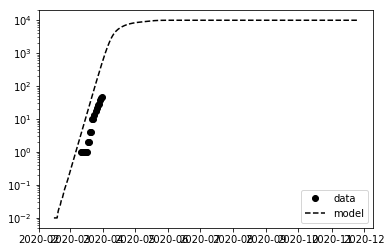

In [165]:
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
x_off = df_merged['Día']
y_off = np.array(df_merged['M'])
x_mod = df_shifted['Día']
y_mod = np.array(df_shifted['average_recover'])*0.01
plt.plot(x_off, y_off, 'ko', label = 'data')
plt.plot(x_mod, y_mod, 'k--', label = 'model')
plt.legend()
plt.yscale('log')

In [168]:
v1=np.arange(0.00001,0.005,0.00001)
chi_2 = dict()
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
for par in v1:
    chi_2[par], kk = chi2(df_merged, 'UCI', 'av_Infected', par)
minchi = np.min(list(chi_2.values()))
print(minchi)
for key, value in chi_2.items():
    if value == minchi:
        mu_uci = key
        print(mu_uci)

552.5613348023842
0.00018


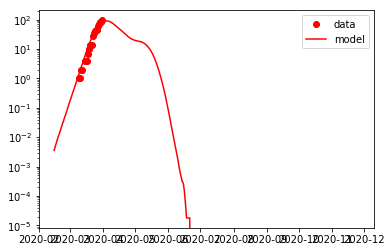

In [167]:
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
x_off = df_merged['Día']
y_off = np.array(df_merged['UCI'])
x_mod = df_shifted['Día']
y_mod = np.array(df_shifted['av_Infected'])*mu_uci
plt.plot(x_off, y_off, 'ro', label = 'data')
plt.plot(x_mod, y_mod, 'r-', label = 'model')
plt.legend()
plt.yscale('log')